In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
#!pip install seaborn

In [122]:
#!pip install nltk

In [123]:
plt.style.use('dark_background')


In [124]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('vader_lexicon')

In [125]:
# Read data
df = pd.read_csv('Reviews.csv')

In [126]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [127]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [128]:
#df = df.head(500)

In [129]:
print(df.shape)

(568454, 10)


<Axes: title={'center': 'Count of Reviews by Score'}, xlabel='Score'>

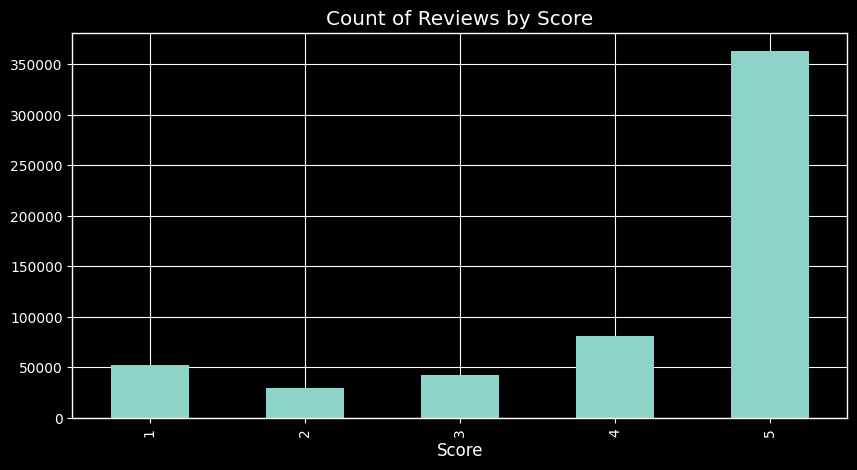

In [130]:
df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by Score',figsize = (10,5))

# Basic NLTK

In [28]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [32]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [36]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [42]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1 VADER Sentiment Scoring

In [131]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [132]:
sia = SentimentIntensityAnalyzer()

In [53]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [54]:
# Run the polarity score on the entire dataset

In [133]:
res = {}
for i, row in tqdm(df.iterrows(),total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)
    

  0%|          | 0/568454 [00:00<?, ?it/s]

In [134]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns= {'index': 'Id'})
vaders = vaders.merge(df, how = 'left')

In [135]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plot VADER results

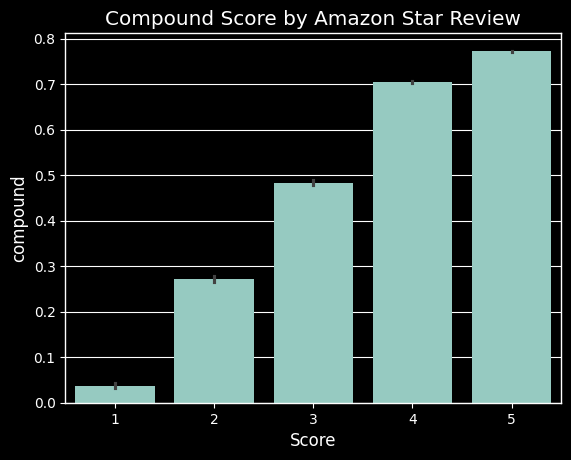

In [136]:
ax =sns.barplot(data = vaders, x ='Score',y = 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

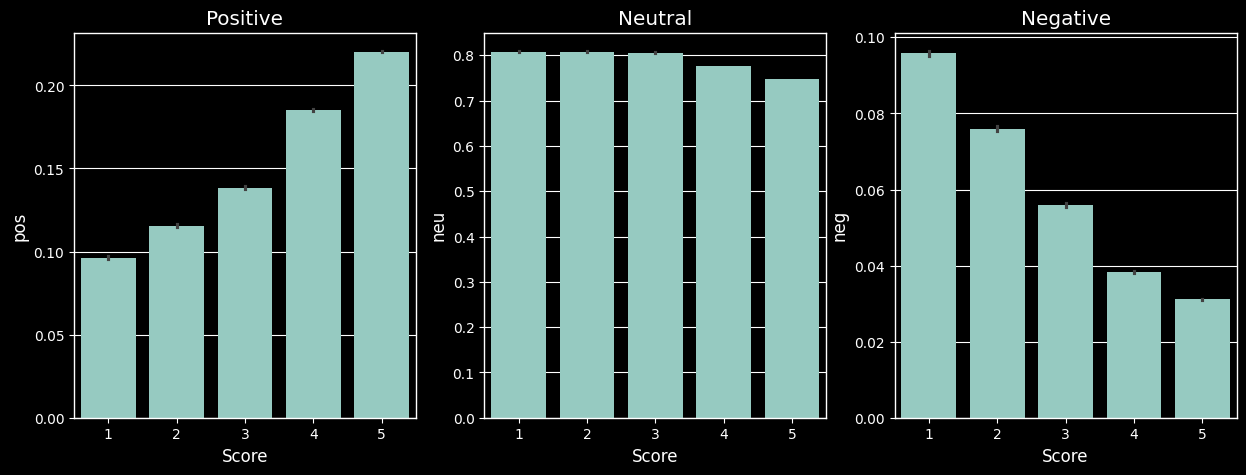

In [137]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data = vaders, x ='Score',y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x ='Score',y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x ='Score',y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# ROBERTA Pretrained model
# Transformer model accounts for the words but also the context related to other words

In [138]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [81]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\deniz\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\deniz\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [82]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [139]:
# Run for the ROBERTA model

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores =output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.0029573706}


In [140]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores =output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return(scores_dict)

In [141]:
#polarity_scores_roberta(example)

In [142]:
res = {}
for i, row in tqdm(df.iterrows(),total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result= sia.polarity_scores(text)
        vader_result_rename= {}
        for key,value in vader_result.items():
            vader_result_rename[f"vader_{key}"]= value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename,**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/568454 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156


KeyboardInterrupt: 

# Combine and Compare

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns= {'index': 'Id'})
results_df = results_df.merge(df, how = 'left')

In [ ]:
results_df.head()

In [ ]:
results_df.columns

In [ ]:
sns.pairplot(data = results_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Review Examples: Positive 1 star and negative 5 star reviews

In [ ]:
# Lets look at some examples where the model scoring and review score differ the most

In [ ]:
results_df.query('Score ==1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score ==1').sort_values('vader_pos',ascending=False)['Text'].values[0]

In [ ]:
#negative sentiment 5-star view

In [ ]:
results_df.query('Score ==5').sort_values('roberta_neg',ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score ==5').sort_values('vader_neg',ascending=False)['Text'].values[0]

# .

In [143]:
#Credit : Rob Mulla

fatal: not a git repository (or any of the parent directories): .git
